# Predicting Apartment Prices in Barcelona 2023

####        ***Luke Atazona, Sebastien Boxho, Mathieu Breier***

Kaggle competition with dataset given (https://www.kaggle.com/competitions/predicting-apartment-prices-in-barcelona-2023/overview)

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import warnings
warnings.filterwarnings("ignore")

In [229]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [230]:
print(df_train.shape)
df_train.head()

(6895, 70)


,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,65,66,65,14,11,12,12,12,NaN,LB
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,65,61,58,10,13,7,6,11,NaN,LDM
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,60,58,59,10,10,8,10,11,NaN,LWB
3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,...,16,22,19,16,15,13,8,9,NaN,LS
4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,...,64,61,58,12,5,11,12,15,NaN,LB


In [231]:
print(df_test.shape)


(767, 69)


In [232]:
df_train.memory_usage()

Index                        132
id                         55160
short_name                 55160
overall                    55160
potential                  55160
                           ...  
goalkeeping_kicking        55160
goalkeeping_positioning    55160
goalkeeping_reflexes       55160
goalkeeping_speed          55160
position                   55160
Length: 71, dtype: int64

# Exploration Data Analysis

In [233]:
df_train.dtypes

id                           int64
short_name                  object
overall                      int64
potential                    int64
value_eur                  float64
                            ...   
goalkeeping_kicking          int64
goalkeeping_positioning      int64
goalkeeping_reflexes         int64
goalkeeping_speed          float64
position                    object
Length: 70, dtype: object

### Missing data and outliers 

Defining the different functions to replace/change/... the data

In [234]:
# Lots of supermarket missing, and orientation
df_train.isna().sum().head(50)

id                               0
short_name                       0
overall                          0
potential                        0
value_eur                        2
wage_eur                         0
birthday_date                    0
height_cm                        0
weight_kg                        0
club_name                        0
league_name                      0
league_level                     0
club_jersey_number               0
club_loaned_from              6544
club_joined                    351
club_contract_valid_until        0
nationality_name                 0
nation_jersey_number          6482
preferred_foot                   0
weak_foot                        0
skill_moves                      0
international_reputation         0
work_rate                        0
body_type                        0
real_face                        0
release_clause_eur             353
player_tags                   6124
player_traits                 2589
pace                

In [235]:
#List the columns with missing values only
df_train.isna().sum()[df_train.isna().sum() > 0]


value_eur                  2
club_loaned_from        6544
club_joined              351
nation_jersey_number    6482
release_clause_eur       353
player_tags             6124
player_traits           2589
pace                     631
shooting                 631
passing                  631
dribbling                631
defending                631
physic                   631
goalkeeping_speed       6264
dtype: int64

In [195]:
import pandas as pd
import numpy as np

def outliers(dataset, threshold=1.5, outlier_percentage_threshold=5):
    """
    Analyze outliers in a dataset and print variables with more than a specified percentage of outliers.

    Parameters:
    - dataset: DataFrame, the input dataset.
    - threshold: float, the threshold for defining outliers. Default is 1.5.
    - outlier_percentage_threshold: float, the threshold for considering a variable to have too many outliers. Default is 5.

    Returns:
    None (prints the result)
    """

    for column in dataset.columns:
        if np.issubdtype(dataset[column].dtype, np.number):
            # Calculate IQR (Interquartile Range)
            q25 = dataset[column].quantile(0.25)
            q75 = dataset[column].quantile(0.75)
            iqr = q75 - q25

            # Define the upper and lower bounds for outliers
            lower_bound = q25 - threshold * iqr
            upper_bound = q75 + threshold * iqr

            # Count the number of outliers
            outliers_count = ((dataset[column] < lower_bound) | (dataset[column] > upper_bound)).sum()

            # Calculate the percentage of outliers
            total_samples = dataset[column].count()
            outlier_percentage = outliers_count / total_samples * 100

            # Print variables with more than the specified percentage of outliers
            if outlier_percentage > outlier_percentage_threshold:
                print(f"Variable with more than 5% of outliers: {column}, Outlier Percentage: {outlier_percentage:.2f}%")



outliers(df_train)


Variable with more than 5% of outliers: value_eur, Outlier Percentage: 13.45%
Variable with more than 5% of outliers: wage_eur, Outlier Percentage: 10.66%
Variable with more than 5% of outliers: league_level, Outlier Percentage: 22.67%
Variable with more than 5% of outliers: weak_foot, Outlier Percentage: 40.44%
Variable with more than 5% of outliers: international_reputation, Outlier Percentage: 10.86%
Variable with more than 5% of outliers: release_clause_eur, Outlier Percentage: 13.42%
Variable with more than 5% of outliers: attacking_heading_accuracy, Outlier Percentage: 8.12%
Variable with more than 5% of outliers: attacking_short_passing, Outlier Percentage: 8.57%
Variable with more than 5% of outliers: skill_dribbling, Outlier Percentage: 9.59%
Variable with more than 5% of outliers: skill_ball_control, Outlier Percentage: 9.69%
Variable with more than 5% of outliers: power_stamina, Outlier Percentage: 9.04%
Variable with more than 5% of outliers: goalkeeping_diving, Outlier Per

In [196]:
# Change the true false values to 0 and 1
def columns_true_false(df, column_name: str):
    #df[column_name] = df[column_name].astype(int)
    df[column_name].replace({True: 1, False: 0}, inplace=True)
    return df  

# Function to fill missing values with the mean
def column_fill_mean(df, column_name:str):
    df[column_name].fillna(df[column_name].mean(), inplace=True)
    return df

# Function to transform the column to float64
def float_to_int(df, column_name:str):
    df[column_name] = df[column_name].astype("Float64")
    return df

# Encodes numerical values to categorical numbers (keeps the NaN values as NaN)
def culumn_string_to_num_encoding(df, name_column: str):
    unique_values = df[name_column].dropna().unique()
    mapping_dict = {value: idx for idx, value in enumerate(unique_values)}
    df[name_column] = df[name_column].map(mapping_dict)
    return df

# fill missing true fales values by random
def random_fill(df, column_name:str):
    df[column_name] = df[column_name].fillna(np.random.choice([True, False], p=[0.5, 0.5]))
    return df

# fill missing values by random from the distribution
def distributed_fill(df, column_name):
    distribution = df[column_name].dropna()
    missing_count = df[column_name].isnull().sum()
    random_samples = np.random.choice(distribution, missing_count)
    df.loc[df[column_name].isnull(), column_name] = random_samples
    return df

# Handle oultiers -> replace values with KNN
def handle_outliers_KNN(df, column_name:str):
    df_copy = df.copy()
    column_data = df_copy[[column_name]].values
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_copy[column_name] = np.where((column_data < lower_bound) | (column_data > upper_bound), np.nan, column_data)

    df_copy = column_fill_KNN(df_copy, column_name)
    return df_copy

# Handle oultiers -> replace values with mean
def handle_outliers_mean(df, column_name:str):
    df_copy = df.copy()
    column_data = df_copy[[column_name]].values
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_copy[column_name] = np.where((column_data < lower_bound) | (column_data > upper_bound), np.nan, column_data)
    df_copy[column_name].fillna(df_copy[column_name].mean(), inplace=True)
    return df_copy

# Check if there are missing values
def has_missing_values(df,column_name:str):
    return df[column_name].isnull().sum() > 0

# normalization znd standardization
def scaling_normalization(df, column_name:str):
    df[column_name] = (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())
    return df

def scaling_standardization(df, column_name:str):
    df[column_name] = (df[column_name] - df[column_name].mean()) / df[column_name].std()
    return df

# fill missing values with KNN
def column_fill_KNN(df, column_name:str, neighbors=10):
    imputer = KNNImputer()
    imputed_data = imputer.fit_transform(df)
    df_temp = pd.DataFrame(imputed_data)
    df_temp.columns = df.columns
    df[column_name] = df_temp[column_name]
    return df

# fill missing values with KNN with weights
def column_fill_KNN_weights(df, column_name:str, weights, neighbors=10):
    df_copy = df.copy()
    data = df_copy[column_name].values
    nan_indices = np.isnan(data)
    weighted_data = data.copy()
    for i in range(len(column_name)):
        weighted_data[:, i] *= weights[i]
    imputer = KNNImputer(n_neighbors=neighbors)
    imputed_data = imputer.fit_transform(weighted_data)
    df_copy[column_name] = np.where(nan_indices, imputed_data, data)
    return df_copy


In [197]:
def handle_cat_col(df,column_names:list):
    for column_name in column_names:
        df = culumn_string_to_num_encoding(df, column_name)
    return df

def handle_tf_col(df,column_names:list):
    for column_name in column_names:
        df = columns_true_false(df, column_name)
    return df

def handle_num_col(df,column_names:list):
    for column_name in column_names:
        df = scaling_normalization(df, column_name)
        df = distributed_fill(df, column_name)
        #df = column_fill_KNN(df, column_name)
    return df

def process_work_rate(row):
    words = row.split('/')
    first_word = words[0].lower()  # Get the first word and convert to lowercase
    
    # Map words to numerical values
    if first_word == 'low':
        return 0
    elif first_word == 'medium':
        return 1
    elif first_word == 'high':
        return 2
    else:
        return None  # Handle unexpected values
    
# Function to process body_type column
def process_body_type(row):
    # Extract the first word from the string
    first_word = row.split()[0].lower()
    
    # Map words to numerical values
    if first_word == 'lean':
        return 0
    elif first_word == 'normal':
        return 1
    elif first_word == 'stocky':
        return 2
    else:
        return None  # Handle unexpected values




In [198]:
# Creating a function that creates a new columns with a number associated to every position in the variable position
def assign_numeric_positions(df, column_name):
    unique_positions = df[column_name].unique()
    position_mapping = {pos: num + 1 for num, pos in enumerate(unique_positions)}
    
    # append a new column with the numeric position
    df['position_num'] = df[column_name].map(position_mapping)
    
    return df
# Assuming df_train is a DataFrame
df_train = assign_numeric_positions(df_train, 'position')

In [199]:
df_train.head()

,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position,position_num
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,66,65,14,11,12,12,12,NaN,LB,1
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,61,58,10,13,7,6,11,NaN,LDM,2
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,58,59,10,10,8,10,11,NaN,LWB,3
3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,...,22,19,16,15,13,8,9,NaN,LS,4
4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,...,61,58,12,5,11,12,15,NaN,LB,1


# Data Processing

### Removing unnecessary columns

In [200]:
# With too much missing values
df_train.drop(['club_loaned_from', 'nation_jersey_number','player_tags','player_traits','goalkeeping_speed'], axis=1, inplace=True)

#

# Cleaned DataFrame Exploration

Some graphs to show some relevant, useful information

In [201]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,id,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_num
id,1.00,-0.34,0.05,-0.08,-0.19,-0.11,-0.18,-0.04,0.08,0.11,-0.09,-0.06,-0.33,-0.06,0.24,-0.24,-0.30,-0.17,-0.14,-0.27,-0.06,-0.06,-0.07,-0.07,-0.13,0.01,-0.13,-0.15,-0.13,-0.03,0.21,0.21,0.04,-0.36,0.07,-0.25,-0.14,0.04,-0.20,-0.12,-0.14,-0.07,-0.05,-0.18,-0.14,-0.32,-0.05,-0.00,0.01,-0.14,-0.15,-0.15,-0.15,-0.14,0.01
overall,-0.34,1.00,0.77,0.64,0.66,0.03,0.10,-0.28,-0.03,0.27,0.20,0.31,0.57,0.63,0.17,0.46,0.67,0.63,0.25,0.36,0.28,0.27,0.22,0.42,0.31,0.30,0.33,0.30,0.41,0.36,0.12,0.13,0.17,0.87,0.09,0.50,0.17,0.19,0.20,0.32,0.26,0.18,0.27,0.46,0.29,0.65,0.17,0.13,0.12,0.08,0.08,0.08,0.08,0.08,0.01
potential,0.05,0.77,1.00,0.60,0.56,0.00,-0.01,-0.22,0.01,0.37,0.15,0.25,0.45,0.61,0.26,0.31,0.50,0.54,0.16,0.15,0.20,0.20,0.12,0.34,0.21,0.27,0.23,0.17,0.31,0.31,0.19,0.20,0.18,0.64,0.12,0.33,0.07,0.12,0.04,0.21,0.14,0.11,0.20,0.36,0.16,0.46,0.11,0.10,0.08,0.05,0.04,0.04,0.04,0.04,0.00
value_eur,-0.08,0.64,0.60,1.00,0.84,0.01,0.03,-0.14,-0.02,0.27,0.16,0.24,0.65,1.00,0.19,0.30,0.42,0.43,0.11,0.18,0.21,0.22,0.13,0.30,0.23,0.24,0.24,0.20,0.27,0.27,0.15,0.16,0.16,0.56,0.11,0.30,0.08,0.15,0.09,0.22,0.14,0.10,0.22,0.33,0.19,0.41,0.09,0.08,0.06,0.00,0.01,0.01,0.00,0.01,0.02
wage_eur,-0.19,0.66,0.56,0.84,1.00,0.03,0.05,-0.14,-0.02,0.24,0.15,0.24,0.69,0.84,0.14,0.30,0.44,0.42,0.14,0.20,0.22,0.22,0.17,0.31,0.24,0.24,0.25,0.22,0.30,0.28,0.12,0.14,0.15,0.59,0.10,0.32,0.11,0.15,0.11,0.23,0.18,0.12,0.22,0.33,0.22,0.44,0.12,0.10,0.09,0.00,0.00,0.00,0.00,0.00,0.01
height_cm,-0.11,0.03,0.00,0.01,0.03,1.00,0.77,0.08,-0.04,0.03,-0.17,-0.44,0.05,0.02,-0.45,-0.24,-0.34,-0.44,0.20,0.53,-0.52,-0.38,0.06,-0.37,-0.35,-0.50,-0.46,-0.43,-0.33,-0.42,-0.58,-0.47,-0.67,0.01,-0.79,-0.19,0.01,-0.34,0.57,-0.40,-0.04,-0.07,-0.45,-0.38,-0.32,-0.16,-0.07,-0.08,-0.08,0.34,0.34,0.34,0.35,0.34,-0.00
weight_kg,-0.18,0.10,-0.01,0.03,0.05,0.77,1.00,0.01,-0.04,-0.00,-0.13,-0.39,0.08,0.03,-0.42,-0.16,-0.27,-0.36,0.18,0.58,-0.46,-0.32,0.06,-0.32,-0.28,-0.44,-0.39,-0.35,-0.28,-0.37,-0.53,-0.44,-0.60,0.07,-0.68,-0.10,0.05,-0.31,0.61,-0.32,0.00,-0.07,-0.39,-0.32,-0.24,-0.10,-0.07,-0.09,-0.09,0.32,0.33,0.33,0.33,0.33,0.01
league_level,-0.04,-0.28,-0.22,-0.14,-0.14,0.08,0.01,1.00,-0.10,-0.02,-0.03,-0.08,-0.13,-0.14,-0.05,-0.11,-0.18,-0.15,-0.07,-0.04,-0.08,-0.06,-0.06,-0.13,-0.08,-0.08,-0.09,-0.07,-0.12,-0.10,-0.03,-0.03,-0.03,-0.23,-0.01,-0.12,-0.01,-0.01,-0.01,-0.08,-0.07,-0.06,-0.08,-0.12,-0.07,-0.16,-0.05,-0.04,-0.04,-0.01,-0.00,-0.01,-0.01,-0.01,0.01
club_jersey_number,0.08,-0.03,0.01,-0.02,-0.02,-0.04,-0.04,-0.10,1.00,0.02,0.02,0.05,-0.01,-0.02,0.07,0.04,0.01,0.03,-0.07,-0.07,0.05,0.06,0.00,0.02,0.06,0.06,0.05,0.03,0.01,0.04,0.07,0.07,0.06,-0.03,0.05,0.04,-0.03,0.01,-0.05,0.06,-0.01,-0.03,0.06,0.03,0.04,0.00,-0.03,-0.02,-0.02,-0.04,-0.04,-0.04,-0.04,-0.04,0.01
club_contract_valid_until,0.11,0.27,0.37,0.27,0.24,0.03,-0.00,-0.02,0.02,1.00,0.06,0.09,0.13,0.28,0.15,0.11,0.17,0.20,0.04,0.05,0.09,0.09,0.06,0.14,0.09,0.12,0.10,0.07,0.11,0.13,0.12,0.12,0.10,0.23,0.06,0.12,0.04,0.08,0.02,0.09,0.05,0.04,0.08,0.12,0.05,0.16,0.04,0.04,0.04,-0.01,-0.01,-0.01,-0.01,-0.01,0.02


In [236]:
# Printing the variables with the highest correlation with the target variable
# Select variables with correlation greater than 0.2 or less than -0.2
selected_variables = simplified_corr[(simplified_corr > 0.1) | (simplified_corr < -0.1)]

# Print the selected variables
print(selected_variables)



weak_foot                     0.106057
skill_moves                   0.176871
defending                    -0.200547
attacking_finishing           0.248811
attacking_heading_accuracy    0.279605
attacking_short_passing       0.185158
attacking_volleys             0.233919
skill_dribbling               0.190937
skill_curve                   0.126771
skill_fk_accuracy             0.117074
skill_ball_control            0.219627
movement_acceleration         0.101493
movement_sprint_speed         0.125368
power_shot_power              0.129703
power_stamina                 0.133885
power_strength                0.131101
power_long_shots              0.192515
mentality_aggression          0.124076
mentality_positioning         0.201422
mentality_penalties           0.245090
mentality_composure           0.142164
goalkeeping_diving           -0.266091
goalkeeping_handling         -0.264240
goalkeeping_kicking          -0.261282
goalkeeping_positioning      -0.263210
goalkeeping_reflexes     

### Interpretation
Variable with the highest correlation with target variable :
- goalkeeping_diving           -0.266091
- goalkeeping_handling         -0.264240
- goalkeeping_kicking          -0.261282
- goalkeeping_positioning      -0.263210
- goalkeeping_reflexes         -0.264880
- attacking_heading_accuracy    0.279605


## Visualization

### Variable Distribution

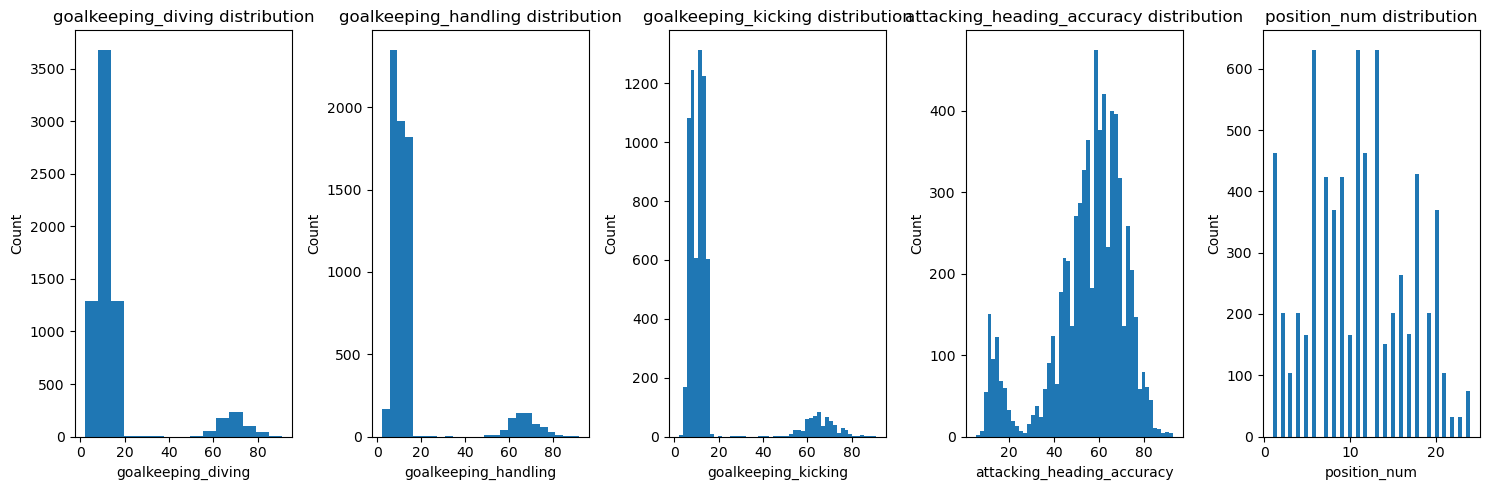

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
plt.hist(df_train['goalkeeping_diving'], bins=15)
plt.xlabel('goalkeeping_diving')
plt.ylabel('Count')
plt.title('goalkeeping_diving distribution')

plt.subplot(1, 5, 2)
plt.hist(df_train['goalkeeping_handling'], bins=25)
plt.xlabel('goalkeeping_handling')
plt.ylabel('Count')
plt.title('goalkeeping_handling distribution')

plt.subplot(1, 5, 3)
plt.hist(df_train['goalkeeping_kicking'], bins=50)
plt.xlabel('goalkeeping_kicking')
plt.ylabel('Count')
plt.title('goalkeeping_kicking distribution')

plt.subplot(1, 5, 4)
plt.hist(df_train['attacking_heading_accuracy'], bins=50)
plt.xlabel('attacking_heading_accuracy')
plt.ylabel('Count')
plt.title('attacking_heading_accuracy distribution')

plt.subplot(1, 5, 5)
plt.hist(df_train['position_num'], bins=50)
plt.xlabel('position_num')
plt.ylabel('Count')
plt.title('position_num distribution')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### Scatter Plot

In [204]:
'''plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
y = df_train["price"]
x = df_train["square_meters"]
plt.scatter(x,y, label= "stars", color= "green",  marker= "o", s=10)
plt.xlabel("Square meters")
plt.ylabel("Price")
plt.title("Scatter Plot of Square Meters vs. Price")
plt.show()

plt.figure(figsize=(15,7))
plt.subplot(2,1,2)
data_copy = df_train.copy()
data_copy['square_meters'] = data_copy['square_meters'].apply(lambda x: abs(x) + 58 if x < 0 else x)
negative_square_meters = data_copy[df_train['square_meters'] < 0]
non_negative_square_meters = data_copy[df_train['square_meters'] >= 0]
plt.scatter(non_negative_square_meters['square_meters'], non_negative_square_meters['price'], color='lightblue', label='Positive Square Meters')
plt.scatter(negative_square_meters['square_meters'], negative_square_meters['price'], color='orangered', label='Negative Square Meters (Absolute Values+cnst.)')
plt.xlabel('Square Meters')
plt.ylabel('Price')
plt.title('Scatter Plot of Square Meters above 50m^2 vs. Price')
plt.legend()
plt.show()'''

'plt.figure(figsize=(15,7))\nplt.subplot(2,1,1)\ny = df_train["price"]\nx = df_train["square_meters"]\nplt.scatter(x,y, label= "stars", color= "green",  marker= "o", s=10)\nplt.xlabel("Square meters")\nplt.ylabel("Price")\nplt.title("Scatter Plot of Square Meters vs. Price")\nplt.show()\n\nplt.figure(figsize=(15,7))\nplt.subplot(2,1,2)\ndata_copy = df_train.copy()\ndata_copy[\'square_meters\'] = data_copy[\'square_meters\'].apply(lambda x: abs(x) + 58 if x < 0 else x)\nnegative_square_meters = data_copy[df_train[\'square_meters\'] < 0]\nnon_negative_square_meters = data_copy[df_train[\'square_meters\'] >= 0]\nplt.scatter(non_negative_square_meters[\'square_meters\'], non_negative_square_meters[\'price\'], color=\'lightblue\', label=\'Positive Square Meters\')\nplt.scatter(negative_square_meters[\'square_meters\'], negative_square_meters[\'price\'], color=\'orangered\', label=\'Negative Square Meters (Absolute Values+cnst.)\')\nplt.xlabel(\'Square Meters\')\nplt.ylabel(\'Price\')\nplt.t

### Boxplot

In [205]:
'''boxplot = sns.boxplot(data=data_copy, x='square_meters', y='price')
plt.setp(boxplot.get_xticklabels(), rotation=45)
plt.title('Boxplot of Price related to Square_meter')
plt.xlabel('Square_meter')
plt.ylabel('Price')
plt.show()'''

"boxplot = sns.boxplot(data=data_copy, x='square_meters', y='price')\nplt.setp(boxplot.get_xticklabels(), rotation=45)\nplt.title('Boxplot of Price related to Square_meter')\nplt.xlabel('Square_meter')\nplt.ylabel('Price')\nplt.show()"

In [206]:
'''boxplot = sns.boxplot(data=df_train, x='num_crimes', y='price')
plt.setp(boxplot.get_xticklabels(), rotation=45)
plt.title('Boxplot of Price per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.show()'''

"boxplot = sns.boxplot(data=df_train, x='num_crimes', y='price')\nplt.setp(boxplot.get_xticklabels(), rotation=45)\nplt.title('Boxplot of Price per Neighborhood')\nplt.xlabel('Neighborhood')\nplt.ylabel('Price')\nplt.show()"

### Distribution of Price

In [207]:
'''plt.figure(figsize=(10, 6))
sns.histplot(df_train["price"], kde=True)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Price")
plt.show()'''

'plt.figure(figsize=(10, 6))\nsns.histplot(df_train["price"], kde=True)\nplt.xlabel("Price")\nplt.ylabel("Count")\nplt.title("Distribution of Price")\nplt.show()'

In [208]:
'''colors = ['green', 'blue']
hue_order = [True, False]

plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='price', hue='has_pool', kde=True, element='step', common_norm=False, stat='density', palette=colors, hue_order=hue_order)
plt.xlabel('Price')
plt.title('Price Distribution with KDE for Has Pool True and False')
plt.show()'''

"colors = ['green', 'blue']\nhue_order = [True, False]\n\nplt.figure(figsize=(8, 6))\nsns.histplot(data=df_train, x='price', hue='has_pool', kde=True, element='step', common_norm=False, stat='density', palette=colors, hue_order=hue_order)\nplt.xlabel('Price')\nplt.title('Price Distribution with KDE for Has Pool True and False')\nplt.show()"

# Regressions

Coding different regressions defined in individual functions

In [209]:
# Linear Regression
def linear_regression_train(X,y,df_t):
    model = LinearRegression()
    model.fit(X, y)
    y_predic = model.predict(X)
    y_test = model.predict(df_t)
    mse = mean_squared_error(y, y_predic)
    mse_std = np.std(y-y_predic)
    r2 = r2_score(y, y_predic)   
    return mse,mse_std, r2, y_test

# Polynomial Regression
def non_linear_regression_train(X,y,df_t,degree=2):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    t_poly = poly_features.fit_transform(df_t)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_test = poly_model.predict(t_poly)
    y_poly_pred = poly_model.predict(X_poly)
    poly_mse = mean_squared_error(y, y_poly_pred)
    mse_std = np.std(y-y_poly_pred)
    r2 = r2_score(y, y_poly_pred)
    return poly_mse,mse_std, r2, y_test

# Lasso Regression
def lasso_regression_train(X,y,df_t,alpha):
    # alpha between 0 and 1
    model = Lasso(alpha)
    model.fit(X, y)
    y_predic = model.predict(X)
    y_test = model.predict(df_t)
    mse = mean_squared_error(y, y_predic)
    r2 = r2_score(y, y_predic)
    return mse, r2, model, y_test

def lasso_regression_train_cv(X,y,cv,df_t):
    lasso_model = LassoCV(alphas=None, cv=cv, max_iter=100000)
    lasso_model.fit(X, y)
    lasso = Lasso(alpha=lasso_model.alpha_)
    lasso.fit(X, y)
    lasso_y_predic = lasso.predict(X)
    y_pred = lasso.predict(df_t)
    mse = mean_squared_error(y, lasso_y_predic)
    mse_std = np.std(y-lasso_y_predic)
    r2 = r2_score(y, lasso_y_predic)
    return mse,mse_std,r2,y_pred

# Polynomial Lasso Regression
def ploy_lasso_regression_train_cv(X,y,cv,df_t, degree=2):
    scaler = StandardScaler()
    standarized_x = scaler.fit_transform(X)
    ploy_model = LassoCV(alphas=None, cv=cv, max_iter=100000).fit(standarized_x, y)
    poly_lasso = Lasso(alpha=ploy_model.alpha_)
    poly_lasso.fit(X, y)
    poly_lasso_y_predic = poly_lasso.predict(X)
    y_pred = poly_lasso.predict(df_t)
    mse = mean_squared_error(y, poly_lasso_y_predic)
    mse_std = np.std(y-poly_lasso_y_predic)
    r2 = r2_score(y, poly_lasso_y_predic)
    return mse,mse_std,r2,y_pred

# Ridge Regression
def ridge_regression_train(X,y,df_t, alpha):
    # alpha 0 and Inf
    model = Ridge(alpha)
    model.fit(X, y)
    y_predic = model.predict(X)
    y_test = model.predict(df_t)
    mse = mean_squared_error(y, y_predic)
    r2 = r2_score(y, y_predic)
    return mse, r2, model, y_test

def ridge_regression_train_cv(X,y,cv,alpha_range_ridge,df_t):
    ridge_model = RidgeCV(alphas=alpha_range_ridge, scoring= 'neg_mean_squared_error', cv=cv)
    ridge_model.fit(X, y)
    ridge = Ridge(alpha=ridge_model.alpha_)
    ridge.fit(X, y)
    ridge_y_predic = ridge.predict(X)
    y_pred = ridge.predict(df_t)
    mse = mean_squared_error(y, ridge_y_predic)
    mse_std = np.std(y-ridge_y_predic)
    r2 = r2_score(y, ridge_y_predic)
    return mse,mse_std,r2,y_pred

# Polynomial Ridge Regression
def poly_ridge_regression_train_cv(X,y,alphas_ridge,cv,df_t,degree=2):
    scaler = StandardScaler()
    standarized_x = scaler.fit_transform(X)
    ploy_model = RidgeCV(alphas=alphas_ridge,scoring= 'neg_mean_squared_error', cv=cv).fit(standarized_x, y)
    poly_ridge = Ridge(alpha=ploy_model.alpha_)
    poly_ridge.fit(X, y)
    poly_ridge_y_predic = poly_ridge.predict(X)
    y_pred = poly_ridge.predict(df_t)
    mse = mean_squared_error(y, poly_ridge_y_predic)
    mse_std = np.std(y-poly_ridge_y_predic)
    r2 = r2_score(y, poly_ridge_y_predic)
    return mse,mse_std,r2,y_pred

# Gradient Boosting Regression
def gradient_boosting_train(X,y,df_t):
    model = HistGradientBoostingRegressor()
    model.fit(X, y)
    y_predic = model.predict(X)
    y_test = model.predict(df_t)
    mse = mean_squared_error(y, y_predic)
    r2 = r2_score(y, y_predic)
    return mse, r2, model, y_test

# Logistic
def logistic_regression_train(X, y, df_t):
    # Normalize the dataset (needed for logistic regression)
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    df_t_normalized = scaler.transform(df_t)

    # Train the logistic regression model
    model = LogisticRegression()
    model.fit(X_normalized, y)
    
    # Make predictions on the training set
    y_predic = model.predict(X_normalized)
    accuracy = accuracy_score(y, y_predic)
    
    # Make predictions on the test set
    y_test = model.predict(df_t_normalized)
    
    # Additional metrics for classification
    confusion_mat = confusion_matrix(y, y_predic)
    classification_rep = classification_report(y, y_predic)
    
    return accuracy, model, y_test, confusion_mat, classification_rep

# Decision Tree
def decision_tree_train(X, y, df_t):
    model = DecisionTreeClassifier()
    model.fit(X, y)
    
    y_predic = model.predict(X)
    accuracy = accuracy_score(y, y_predic)
    
    y_test = model.predict(df_t)
    
    # Additional metrics for classification
    confusion_mat = confusion_matrix(y, y_predic)
    classification_rep = classification_report(y, y_predic)
    
    return accuracy, model, y_test, confusion_mat, classification_rep

# Random Forest
def random_forest_train(X, y, df_t):
    model = RandomForestClassifier()
    model.fit(X, y)
    
    y_predic = model.predict(X)
    accuracy = accuracy_score(y, y_predic)
    
    y_test = model.predict(df_t)
    
    # Additional metrics for classification
    confusion_mat = confusion_matrix(y, y_predic)
    classification_rep = classification_report(y, y_predic)
    
    return accuracy, model, y_test, confusion_mat, classification_rep

# Function that categorizes the columns of a dataframe into continuous, binary and string
def categorize_columns(df):
    categorized_columns = {
        'continuous': [],
        'binary': [],
        'string': []
    }
    
    for column in df.columns:
        unique_values = df[column].dropna().unique()
        if len(unique_values) <= 2 and (0 in unique_values or 1 in unique_values or True in unique_values or False in unique_values):
            categorized_columns['binary'].append(column)
        elif df[column].dtype in ['int64', 'float64','Int64']:
            categorized_columns['continuous'].append(column)
        else:
            categorized_columns['string'].append(column)
    
    return categorized_columns

# Function to evaluate the models
def evaluate(model, X, y, cv):
    cv_results = cross_val_score(model, X, y, cv=cv, scoring=['test_neg_mean_squared_error','test_r2'], return_estimator=True)
    mae = -cv_results['test_neg_mean_squared_error']
    r2 = cv_results['test_r2']
    eval_model = cv_results['estimator']
    print(
        f"Mean Absolute Error:      {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"R2:                       {r2.mean():.3f} +/- {r2.std():.3f}"
    )
    return eval_model

# Function to run a cross validation
def cross_val(split):
    if split == 1:
        cross = KFold(n_splits=3, shuffle=True, random_state=42)
    elif split == 2:
        cross = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    elif split == 3:
        cross = KFold(n_splits=6, shuffle=True, random_state=42)
    elif split == 4:
        cross = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    #elif split == 5:
        #cross = LeaveOneOut()
    else:
        cross = None
    return cross
        


## Data preprocessing

Variable with more than 5% of outliers: value_eur, Outlier Percentage: 13.45%
Variable with more than 5% of outliers: wage_eur, Outlier Percentage: 10.66%
Variable with more than 5% of outliers: league_level, Outlier Percentage: 22.67%
Variable with more than 5% of outliers: weak_foot, Outlier Percentage: 40.44%
Variable with more than 5% of outliers: international_reputation, Outlier Percentage: 10.86%
Variable with more than 5% of outliers: release_clause_eur, Outlier Percentage: 13.42%
Variable with more than 5% of outliers: attacking_heading_accuracy, Outlier Percentage: 8.12%
Variable with more than 5% of outliers: attacking_short_passing, Outlier Percentage: 8.57%
Variable with more than 5% of outliers: skill_dribbling, Outlier Percentage: 9.59%
Variable with more than 5% of outliers: skill_ball_control, Outlier Percentage: 9.69%
Variable with more than 5% of outliers: power_stamina, Outlier Percentage: 9.04%
Variable with more than 5% of outliers: goalkeeping_diving, Outlier Percentage: 9.20%
Variable with more than 5% of outliers: goalkeeping_handling, Outlier Percentage: 9.20%
Variable with more than 5% of outliers: goalkeeping_kicking, Outlier Percentage: 9.24%
Variable with more than 5% of outliers: goalkeeping_positioning, Outlier Percentage: 9.20%
Variable with more than 5% of outliers: goalkeeping_reflexes, Outlier Percentage: 9.20%

In [210]:
# Summarizing the function above in one single function to be applied to our dataset
# Function that process the dataset 
def datasets_processing(d_train,d_test):
    data = pd.concat([d_train,d_test])

    #removing columns with too much missing values
    # With too much missing values
    data.drop(['club_loaned_from', 'nation_jersey_number','player_tags','player_traits','goalkeeping_speed'], axis=1, inplace=True)

    # Removing unnecessary columns
    data.drop(['short_name', 'club_name','league_name','nationality_name','real_face','club_joined'], axis=1, inplace=True)
    
    # Binary
    data = columns_true_false(data, 'preferred_foot')

    # Categorical
    # work rate
    data['work_rate'].apply(process_work_rate)

    # body type
    data['body_type'].apply(process_body_type)
    

    #outliers
    '''data = column_square_meters_NAN(data)
    data = column_num_rooms_NAN(data)'''
    
    #Keeping id on the side
    data_id = data['id']
    data.drop(['id'], axis=1, inplace=True)

    #categorization
    columns_catergorized = categorize_columns(data)
    columns_catergorized['string'].remove('position')

    #handle categorical columns
    data = handle_cat_col(data, columns_catergorized['string'])
    data = handle_tf_col(data, columns_catergorized['binary'])
    data = handle_num_col(data, columns_catergorized['continuous']) 


    data = pd.concat([data_id,data],axis=1)

    ftrain = data.loc[data['position'].notnull()]
    ftest = data.loc[data['position'].isnull()]

    return ftrain,ftest


def datasets_processing_finetuning(d_train,d_test):
    columns_order = ['price','square_meters','num_crimes','floor', 'num_rooms','neighborhood','num_baths',
                    'year_built','num_supermarkets','accepts_pets','is_furnished','has_ac','orientation','has_pool']

    #outliers
    '''d_train = column_square_meters_NAN(d_train)
    d_train = column_num_rooms_NAN(d_train)'''
    
    #Keeping id on the side
    d_train_id = d_train['id']
    d_train.drop(['id'], axis=1, inplace=True)

    columns_catergorized = categorize_columns(d_train)
    columns_catergorized['string'].remove('position')

    d_train = handle_cat_col(d_train, columns_catergorized['string'])
    d_train = handle_tf_col(d_train, columns_catergorized['binary'])
    
    dis_col = ['club_joined','release_clause_eur']
    mean_col = ['pace','shooting','passing','dribbling','defending','physic','work_rate','body_type']
    knn_col = ['value_eur']

    # Filling missing values
    for column_name in dis_col[::-1]:
        d_train = distributed_fill(d_train, column_name)

    for column_name in mean_col[::-1]:
        d_train = column_fill_mean(d_train, column_name)
    
    #for column_name in knn_col[::-1]:
    #    d_train = column_fill_KNN(d_train, column_name)

    d_train = pd.concat([d_train_id,d_train],axis=1)
    
    # Apply same changes to test data
    # Outliers
    '''d_test = column_square_meters_NAN(d_test)
    d_test = column_num_rooms_NAN(d_test)'''

    data = pd.concat([d_train,d_test])
    data_id = data['id']
    data.drop(['id'], axis=1, inplace=True)
    #data = data[columns_order]
    data = handle_cat_col(data, columns_catergorized['string'])
    data = handle_tf_col(data, columns_catergorized['binary'])

    for column_name in dis_col[::-1]:
        data = distributed_fill(data, column_name)
        data = scaling_normalization(data, column_name)

    for column_name in mean_col[::-1]:
        data = column_fill_mean(data, column_name)
        data = scaling_normalization(data, column_name)
    
    for column_name in knn_col[::-1]:
        data = column_fill_KNN(data, column_name)
        data = scaling_normalization(data, column_name)

    data = pd.concat([data_id,data],axis=1)
    ftrain = data.loc[data['price'].notnull()]
    ftest = data.loc[data['price'].isnull()]

    return ftrain, ftest


In [211]:
#print nas in ftrain
print(ftrain.isna().sum()[ftrain.isna().sum() > 0])

work_rate    6895
body_type    6895
dtype: int64


In [212]:
'''#FROM PREDICT
# Summarizing the function above in one single function to be applied to our dataset
# Function that process the dataset 
def datasets_processing(d_train,d_test):
    data = pd.concat([d_train,d_test])
    data = column_orientation_typo(data)
    data = column_floor(data)

    data = column_square_meters_NAN(data)
    data = column_num_rooms_NAN(data)
    data_id = data['id']
    data.drop(['door','id'], axis=1, inplace=True)

    columns_catergorized = categorize_columns(data)
    columns_catergorized['continuous'].remove('price')

    data = handle_cat_col(data, columns_catergorized['string'])
    data = handle_tf_col(data, columns_catergorized['binary'])
    data = handle_num_col(data, columns_catergorized['continuous']) 

    data = pd.concat([data_id,data],axis=1)

    ftrain = data.loc[data['price'].notnull()]
    ftest = data.loc[data['price'].isnull()]

    return ftrain,ftest

def datasets_processing_finetuning(d_train,d_test):
    columns_order = ['price','square_meters','num_crimes','floor', 'num_rooms','neighborhood','num_baths',
                    'year_built','num_supermarkets','accepts_pets','is_furnished','has_ac','orientation','has_pool']

    d_train = column_orientation_typo(d_train)
    d_train = column_floor(d_train)
    
    d_train = column_square_meters_NAN(d_train)
    d_train = column_num_rooms_NAN(d_train)
    d_train_id = d_train['id']
    d_train.drop(['door','id'], axis=1, inplace=True)

    
    columns_catergorized = categorize_columns(d_train)
    columns_catergorized['continuous'].remove('price')

    d_train = handle_cat_col(d_train, columns_catergorized['string'])
    d_train = handle_tf_col(d_train, columns_catergorized['binary'])
    
    dis_col = ['has_ac','orientation']
    mean_col = ['num_baths']
    knn_col = ['square_meters','num_crimes','floor','num_rooms','neighborhood','year_built','num_supermarkets','accepts_pets','is_furnished','has_pool']

    for column_name in dis_col[::-1]:
        d_train = distributed_fill(d_train, column_name)

    for column_name in mean_col[::-1]:
        d_train = column_fill_mean(d_train, column_name)
    
    for column_name in knn_col[::-1]:
        d_train = column_fill_KNN(d_train, column_name)

    d_train = pd.concat([d_train_id,d_train],axis=1)
    
    # Apply same changes to test data
    d_test = column_orientation_typo(d_test)
    d_test = column_floor(d_test)

    d_test = column_square_meters_NAN(d_test)
    d_test = column_num_rooms_NAN(d_test)
    d_test.drop(['door'], axis=1, inplace=True)

    data = pd.concat([d_train,d_test])
    data_id = data['id']
    data.drop(['id'], axis=1, inplace=True)
    data = data[columns_order]
    data = handle_cat_col(data, columns_catergorized['string'])
    data = handle_tf_col(data, columns_catergorized['binary'])

    for column_name in dis_col[::-1]:
        data = distributed_fill(data, column_name)
        data = scaling_normalization(data, column_name)

    for column_name in mean_col[::-1]:
        data = column_fill_mean(data, column_name)
        data = scaling_normalization(data, column_name)
    
    for column_name in knn_col[::-1]:
        data = column_fill_KNN(data, column_name)
        data = scaling_normalization(data, column_name)

    data = pd.concat([data_id,data],axis=1)
    ftrain = data.loc[data['price'].notnull()]
    ftest = data.loc[data['price'].isnull()]

    return ftrain, ftest
    '''

"#FROM PREDICT\n# Summarizing the function above in one single function to be applied to our dataset\n# Function that process the dataset \ndef datasets_processing(d_train,d_test):\n    data = pd.concat([d_train,d_test])\n    data = column_orientation_typo(data)\n    data = column_floor(data)\n\n    data = column_square_meters_NAN(data)\n    data = column_num_rooms_NAN(data)\n    data_id = data['id']\n    data.drop(['door','id'], axis=1, inplace=True)\n\n    columns_catergorized = categorize_columns(data)\n    columns_catergorized['continuous'].remove('price')\n\n    data = handle_cat_col(data, columns_catergorized['string'])\n    data = handle_tf_col(data, columns_catergorized['binary'])\n    data = handle_num_col(data, columns_catergorized['continuous']) \n\n    data = pd.concat([data_id,data],axis=1)\n\n    ftrain = data.loc[data['price'].notnull()]\n    ftest = data.loc[data['price'].isnull()]\n\n    return ftrain,ftest\n\ndef datasets_processing_finetuning(d_train,d_test):\n    co

In [213]:
# Function that runs every classification model defined within the function and return the best model with the lowest MSE

def best_classifier(df, df_t):
    best_models = []

    df, df_t = datasets_processing(df, df_t)  
    
    # Shuffle the DataFrame to avoid ordering bias
    df = shuffle(df, random_state=42)
    
    df_t_id = df_t['id']
    df_t = df_t.drop(columns=['position','id'])
    X = df.drop(columns=['position','id'])
    y = df['position']

    # Decision Tree
    dt_accuracy, dt_model, dt_y_test, dt_conf_mat, dt_class_rep = decision_tree_train(X, y, df_t)
    best_models.append(('Decision Tree', dt_accuracy, dt_model, dt_y_test, dt_conf_mat, dt_class_rep))
    
    # Logistic Regression
    lr_accuracy, lr_model, lr_y_test, lr_conf_mat, lr_class_rep = logistic_regression_train(X, y, df_t)
    best_models.append(('Logistic Regression', lr_accuracy, lr_model, lr_y_test, lr_conf_mat, lr_class_rep))
    
    # Random Forest
    rf_accuracy, rf_model, rf_y_test, rf_conf_mat, rf_class_rep = random_forest_train(X, y, df_t)
    best_models.append(('Random Forest', rf_accuracy, rf_model, rf_y_test, rf_conf_mat, rf_class_rep))
    
    # Find the overall best model based on the highest accuracy
    overall_best_model = max(best_models, key=lambda x: x[1]) 
    
    # Print and return the best model information
    print("Best Classification Model (Accuracy): ", overall_best_model[0])
    print("Accuracy:", overall_best_model[1])
    print("Confusion Matrix:\n", overall_best_model[4])
    print("Classification Report:\n", overall_best_model[5])
    
    return overall_best_model, df_t_id

# Call the function
best_classifier_result, df_t_id = best_classifier(df_train, df_test)


Best Classification Model (Accuracy):  Decision Tree
Accuracy: 1.0
Confusion Matrix:
 [[263   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 167   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 151   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  75   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 631   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 463   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 631   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 423   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 201   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0

In [214]:
'''#FROM PREDICT
# Function that runs every model defined within the function and return the best model with the lowest MSE
def best_predictor(df, df_t):
    best_models = []
    alpha_range = range(0, 100)

    df, df_t = datasets_processing(df, df_t)  
    
    # Shuffle the DataFrame to avoid ordering bias
    df = shuffle(df, random_state=42)
    
    df_t_id = df_t['id']
    df_t = df_t.drop(columns=['price','id'])
    X = df.drop(columns=['price','id'])
    y = df['price']

    # Loop through each alpha value for Lasso and Ridge regression
    for alpha in alpha_range:

        # Linear Regression
        linear_mse, linear_r2, linear_model, y_pred= linear_regression_train(X,y,df_t)
        
        # Nonlinear Regression
        if alpha < 4:
            nonlinear_mse, nonlinear_r2, nonlinear_model, y_pred = non_linear_regression_train(X,y,df_t,alpha)
        
        # Ridge Regression
        ridge_mse, ridge_r2, ridge_model, y_pred = ridge_regression_train(X,y,df_t,alpha)
        
        alpha = alpha/100
        # Lasso Regression
        lasso_mse, lasso_r2, lasso_model, y_pred = lasso_regression_train(X,y,df_t,alpha)

        # Compare MSE values and keep the best model for each regression type
        best_model = min([('linear',linear_mse, linear_r2, linear_model,y_pred,alpha),
                          ('nonlinear',nonlinear_mse, nonlinear_r2, nonlinear_model,y_pred,alpha),
                          ('lasso',lasso_mse, lasso_r2, lasso_model,y_pred,alpha),
                          ('ridge',ridge_mse,ridge_r2, ridge_model,y_pred,alpha)], key=lambda x: x[1])
        
        best_models.append(best_model)
    
    # Find the overall best model based on the lowest MSE
    print("Len_best_models: ",len(best_models))
    overall_best_model = min(best_models, key=lambda x: x[1]) 
    
    # Print and return the best model information
    print("Best Regression Model (MSE): ", overall_best_model)
    print("MSE:", overall_best_model[1])
    print("R^2 Score:", overall_best_model[2])
    print("Alpha:", overall_best_model[5])
    
    return overall_best_model, df_t_id

def best_cross_val_predictor(df, df_t):
    best_lasso = []
    best_lasso_poly = []
    best_ridge = []
    best_ridge_poly = []
    best_linear = []
    best_non_linear = []
    best_models = []
    alpha_range_ridge = 10**np.linspace(10,-2,100)*0.5

    df, df_t = datasets_processing_finetuning(df, df_t)

    df_t = df_t.drop(columns=['price','id'])
    X = df.drop(columns=['price','id'])
    y = df['price']

    for i in range(1,5):
        print("Run number: ",i)
        cv = cross_val(i)
        
        for j in range(1,11):
            lr_mse, lr_mse_std , lr_r2, y_pred = linear_regression_train(X,y,df_t)
            best_linear.append((lr_mse,lr_mse_std,lr_r2,y_pred))

            nlr_mse, nlr_mse_std , nlr_r2, y_pred = non_linear_regression_train(X,y,df_t,3)
            best_non_linear.append((nlr_mse,nlr_mse_std,nlr_r2,y_pred))

            lasso_mse, lasso_mse_std , lasso_r2, y_pred = lasso_regression_train_cv(X,y,cv,df_t)
            best_lasso.append((lasso_mse,lasso_mse_std,lasso_r2,y_pred))

            poly_lasso_mse, poly_lasso_mse_std , poly_lasso_r2, y_pred = ploy_lasso_regression_train_cv(X,y,cv,df_t,3)
            best_lasso_poly.append((poly_lasso_mse,poly_lasso_mse_std,poly_lasso_r2,y_pred))

            ridge_mse, ridge_mse_std , ridge_r2, y_pred = ridge_regression_train_cv(X,y,cv,alpha_range_ridge,df_t)
            best_ridge.append((ridge_mse,ridge_mse_std,ridge_r2,y_pred))

            poly_ridge_mse, poly_ridge_mse_std , poly_ridge_r2, y_pred = poly_ridge_regression_train_cv(X,y,alpha_range_ridge,cv,df_t,3)
            best_ridge_poly.append((poly_ridge_mse,poly_ridge_mse_std,poly_ridge_r2,y_pred))
        
        
    best_models.append(min(best_linear, key=lambda x: x[0]))
    best_models.append(min(best_non_linear, key=lambda x: x[0]))
    best_models.append(min(best_lasso, key=lambda x: x[0]))
    best_models.append(min(best_lasso_poly, key=lambda x: x[0]))
    best_models.append(min(best_ridge, key=lambda x: x[0]))
    best_models.append(min(best_ridge_poly, key=lambda x: x[0]))
    
    return best_models'''

'#FROM PREDICT\n# Function that runs every model defined within the function and return the best model with the lowest MSE\ndef best_predictor(df, df_t):\n    best_models = []\n    alpha_range = range(0, 100)\n\n    df, df_t = datasets_processing(df, df_t)  \n    \n    # Shuffle the DataFrame to avoid ordering bias\n    df = shuffle(df, random_state=42)\n    \n    df_t_id = df_t[\'id\']\n    df_t = df_t.drop(columns=[\'price\',\'id\'])\n    X = df.drop(columns=[\'price\',\'id\'])\n    y = df[\'price\']\n\n    # Loop through each alpha value for Lasso and Ridge regression\n    for alpha in alpha_range:\n\n        # Linear Regression\n        linear_mse, linear_r2, linear_model, y_pred= linear_regression_train(X,y,df_t)\n        \n        # Nonlinear Regression\n        if alpha < 4:\n            nonlinear_mse, nonlinear_r2, nonlinear_model, y_pred = non_linear_regression_train(X,y,df_t,alpha)\n        \n        # Ridge Regression\n        ridge_mse, ridge_r2, ridge_model, y_pred = ridge

In [217]:
data_train = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")
best_model_info = best_classifier(data_train,data_test)

Best Classification Model (Accuracy):  Decision Tree
Accuracy: 1.0
Confusion Matrix:
 [[263   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 167   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 151   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  75   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 631   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 463   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 631   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 423   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 201   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0

# Finding the best model

In [218]:
print("Logistic Regression: Accuracy:          ", best_model_info[0][0])
print("Decision Tree: Accuracy:                ", best_model_info[1][0])
print("Random Forest: Accuracy:                ", best_model_info[2][0])


Logistic Regression: Accuracy:           Decision Tree
Decision Tree: Accuracy:                 215562


IndexError: tuple index out of range

In [219]:
y_pred = best_model_info[5][3]
df_id = data_test['id']

IndexError: tuple index out of range

# Predicting the Price

In [220]:
print(len(y_pred))
test_predictions_submit = pd.DataFrame({"id": df_id, "price": y_pred})
print(len(test_predictions_submit))
test_predictions_submit.to_csv("test_predictions_submit_poly_ridge.csv", index = False)
test_predictions_submit.head(20)

NameError: name 'y_pred' is not defined